In [1]:
import numpy as np
from matplotlib import pyplot as plt
from BayersianModel import BayersianModel
from Prior import Prior
from copy import deepcopy
import pandas as pd
import os
from scipy.stats import expon
from MCMC import NaiveSampler

# the Gilespe simulation of hydrogens

it has done before, the parameters are

- $k_1$: binding reaction rate
- $k_2$: breaking reaction rate
- $N_H$: number of $H$
- $N_{H_2}$: number of $H_2$
- $T$: total time of simulation

and I am just going to copy my previous codes here

In [2]:
k1 = .4
k2 = .2
theta = (k1,k2)
NH = 10
NH2 = 10
T = 1

# here are some other parameters that is unrelevant to gilespe
data_size = 2
k1_range = (.01,4)
k2_range = (.01,4)
parameter_range = (k1_range,k2_range)

area = (k1_range[1]-k1_range[0])*(k2_range[1]-k2_range[0])

In [3]:
def product(a,b):
    '''
    this returns the product of
    b * (b-1) * (b-2) * ... * (b-a+1)
    '''
    
    if a == 0:
        return 1
    if b < a:
        return 0
    return np.product(np.arange(b-a+1,b+1,1))

In [4]:
# compounds should be a dictionary, key = name of the conpund, val = quantity of the counpound. 

class reaction:
    
    def __init__(self,input_compounds, output_compounds, reaction_rate, name=None):
        
        self.input = input_compounds
        self.output = output_compounds
        self.rr = reaction_rate
        self.name = name
    
    def proba(self,i):
        
        return self.rr * np.product([product(self.input[key],i[key]) for key in self.input])
    
class chemical_system:
    
    def __init__(self, chemicals, reactions):
        
        self.chemicals = deepcopy(chemicals)
        self.reactions = reactions
    
    def gillespie(self,t,T):
        
        # calculate probability
        A = [reaction.proba(self.chemicals) for reaction in self.reactions]
        a = sum(A)
                
        # sampling next time
        dt = np.random.exponential(1/sum(A))
        
        if t + dt > T:
            return None
        
        # sampling next action
        A = A/a
        action = np.random.choice(self.reactions,1,False,A)[0]
        
        # take the action. 
        for c in self.chemicals:
            self.chemicals[c] -= action.input[c]
            self.chemicals[c] += action.output[c]
            if self.chemicals[c] < 0:
                assert(False)
        
        return t + dt
        
    def simulation(self, T, record=False):
        
        chemicals = deepcopy(self.chemicals)
        
        t = 0
        
        if record:
            records = [[t] + list(self.chemicals.values())]
        
        while t != None:
            t = self.gillespie(t,T)
            if record and t != None:
                records.append([t] + list(self.chemicals.values()))
        
        # reset
        self.chemicals = chemicals

        if record:
            records = pd.DataFrame(data=records,columns=['time']+ list(self.chemicals.keys()))
            return records
        
           

In [5]:
chemicals = {
    "O_2": NH2,
    "O":   NH
    }

binding = reaction(
    input_compounds  = {'O':2, 'O_2':0},
    output_compounds = {'O':0, 'O_2':1},
    reaction_rate    = k1
)

breaking = reaction(
    input_compounds={'O':0, 'O_2':1},
    output_compounds={'O':2, 'O_2':0},
    reaction_rate = k2
)

reactions = [binding, breaking]


def init_chemical_system():
    return chemical_system(chemicals,reactions)

In [6]:
chem_sys = init_chemical_system()
records = chem_sys.simulation(T=T, record=True)

<AxesSubplot:xlabel='time'>

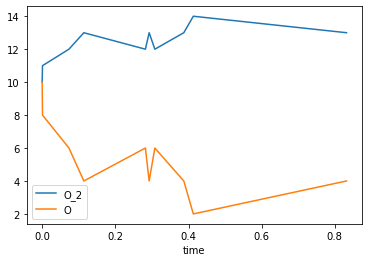

In [7]:
records.set_index('time').plot()

-----

the above shows that I can generate the gillespie samples. 

Now I can generate bunch of them for `observation` and write down the likelyhood, etc, for inference. 

## data gen and plotting

In [8]:
observation = [chem_sys.simulation(T=T,record=True).to_numpy() for i in range(data_size)]

In [9]:
[len(i) for i in observation] # this is the number of reactions happened for each simulation

[7, 11]

## likelyhood

this tries to compute the likelyhood given
- parameter
- outcome

it is a log likelyhood

In [10]:
def log_likelyhood(theta, observation, T=T):
    
    '''
    theta: (k1,k2)
    observation: an n*3 array, where n is number of reactions, and 3 is for (t, O1, O2)
    '''
    
    ret = 0
    
    k1,k2 = theta
    
    binding = reaction(
        input_compounds  = {'O':2, 'O_2':0},
        output_compounds = {'O':0, 'O_2':1},
        reaction_rate    = k1)

    breaking = reaction(
        input_compounds={'O':0, 'O_2':1},
        output_compounds={'O':2, 'O_2':0},
        reaction_rate = k2)
    
    reactions = [binding,breaking]
    
    for sample in observation:
        
        prev_t, prev_n1, prev_n2 = sample[0]
        
        for t,n1,n2 in sample[1:]:
            # the probability of each step is depends on 
            # dt and binding or not. 
            
            reaction_rates = [reaction.proba({'O_2':prev_n1,'O':prev_n2}) 
                            for reaction in reactions]
            propensity = sum(reaction_rates)
            dt = t - prev_t
            p = reaction_rates[0]/propensity if n1>prev_n1 else\
                reaction_rates[1]/propensity
            
            try:
                ret += expon.logpdf(dt, scale=1/propensity) + np.log(p)
            except:
                print(p,reaction_rates,propensity)
                assert(False)
            prev_t, prev_n1, prev_n2 = t,n1,n2
    
    # the final time that nothing happens
    propensity = sum([reaction.proba({'O_2':prev_n1,'O':prev_n2}) for reaction in reactions])
    remaining_time = T - t
    
    ret += -remaining_time/propensity
    
    return ret    

In [ ]:
np.argmax()

assume the prior is just a uniform distribution of the square, let's construct the prior

In [11]:
prior = Prior(
    log_pdf = lambda _ : -np.log(area),
    sampler = lambda : (np.random.uniform(*k1_range),np.random.uniform(*k2_range)),
    theta_range = parameter_range
)

In [12]:
model = BayersianModel(
    prior = prior,
    observation = observation,
    log_likelyhood = log_likelyhood,
)

**cautious**, the following heat diagram generated with 2 minutes of time. don't re-compute it 

computing posterior: 100%|██████████| 10000/10000 [00:09<00:00, 1082.01it/s]


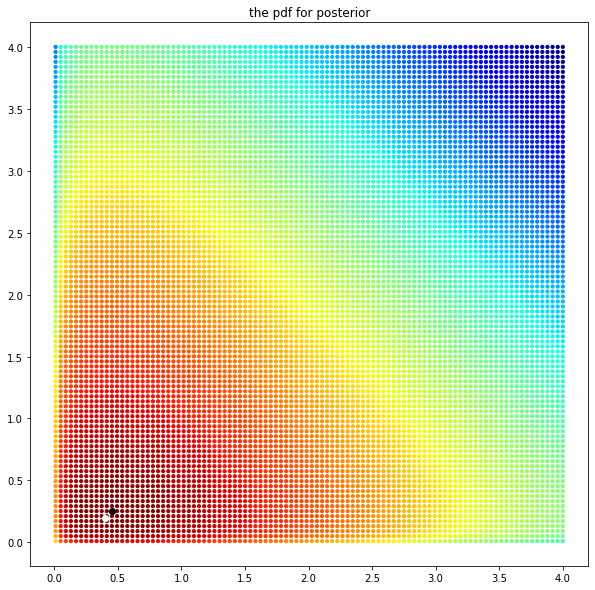

In [13]:
trueplot = model.posterior_heatmap(n=(100,100),s=10,true_theta=theta)

## inference

this inference is very slow because evaluating the log_posterior_proba is too expansive. 

In [49]:
mcmc = NaiveSampler(model=model)
posterior_samples = mcmc.simulation(theta_range='positive',box_size=.1, n=int(5e4))

sampling posterior:   6%|▌         | 2797/50100 [00:05<01:29, 530.27it/s]/var/folders/tl/c_q79z3x4nx7f2p1700yhkcr0000gn/T/ipykernel_68200/1912106658.py:40: RuntimeWarning: invalid value encountered in log
  ret += expon.logpdf(dt, scale=1/propensity) + np.log(p)
sampling posterior: 100%|██████████| 50100/50100 [01:37<00:00, 515.94it/s]


## plot

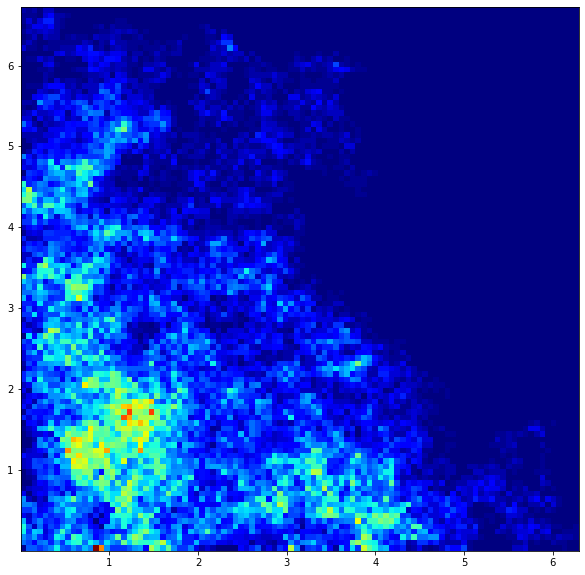

In [56]:
XX, YY = posterior_samples.T
plt.figure(figsize=(10,10))
ax = plt.hist2d(XX,YY,bins=(100,100),cmap='jet')
print()

In [57]:
import statsmodels.api as sm

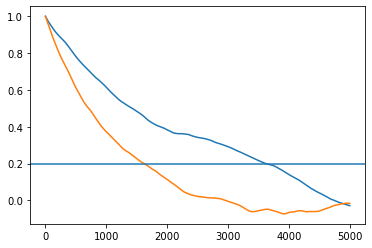

In [58]:
plt.plot(sm.tsa.acf(posterior_samples[:,1],nlags=5000))
plt.plot(sm.tsa.acf(posterior_samples[:,0],nlags=5000))
# plt.xscale('log')
plt.axhline(0.2)


In [59]:
tau = 2000

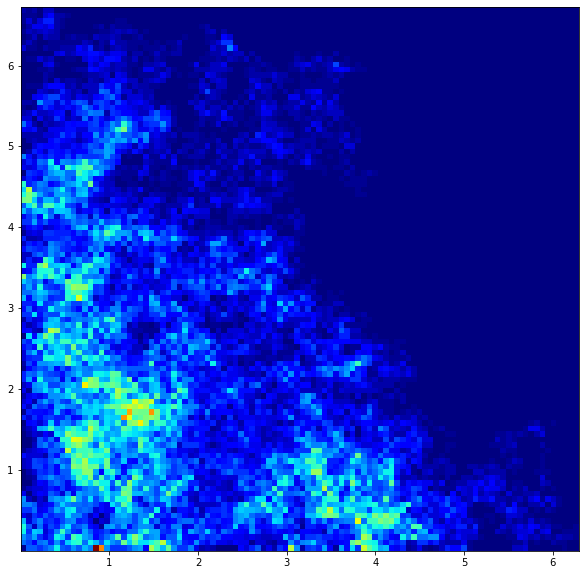

In [60]:
XX, YY = posterior_samples[2*tau:].T
plt.figure(figsize=(10,10))
ax = plt.hist2d(XX,YY,bins=(100,100),cmap='jet')
print()

approximately $\tau \in [1000,3000]$, which means my effective samples is roughly 20-30... wow